In [1]:
# Import public packages and functions
import os
import pandas as pd
import numpy as np
import sys
import json
from pathlib import Path
from scipy import signal

import seaborn as sns
import matplotlib.pyplot as plt
import scikit_posthocs as sp

import warnings
warnings.filterwarnings("ignore")

# inserting the lib folder to the compiler
sys.path.insert(0, './lib')
sys.path.insert(0, './utils/')

import utils_io, utils_phase_analysis, utils_plotting

from lib_data import DATA_IO

In [2]:
PATH_CURR = os.path.abspath(os.curdir)    # current code
PATH      = (str(Path(PATH_CURR).parent)) # data repository: upper directory where datasets situated
fs        = 2048

# 1. Load Events

In [3]:
# load LFP events
EVENTS_LFP             = utils_io.load_LFP_events(event_category="tapping", stn_areas=["motor"], fs=2048)
EVENTS_LFP_MOTOR_LID   = EVENTS_LFP['motor']['controlateral']['LID']
EVENTS_LFP_MOTOR_noLID = EVENTS_LFP['motor']['controlateral']['noLID']

EVENTS_LFP_MOTOR_LID   = EVENTS_LFP_MOTOR_LID[EVENTS_LFP_MOTOR_LID.duration>=0.5]
EVENTS_LFP_MOTOR_noLID = EVENTS_LFP_MOTOR_noLID[EVENTS_LFP_MOTOR_noLID.duration>=0.5]

EVENTS_LFP_MOTOR_LID["hemisphere"]   = EVENTS_LFP_MOTOR_LID["LFP_hemisphere"] 
EVENTS_LFP_MOTOR_LID["channel"]      = EVENTS_LFP_MOTOR_LID["LFP_channel"] 
EVENTS_LFP_MOTOR_noLID["hemisphere"] = EVENTS_LFP_MOTOR_noLID["LFP_hemisphere"] 
EVENTS_LFP_MOTOR_noLID["channel"]    = EVENTS_LFP_MOTOR_noLID["LFP_channel"] 

relevant_features  = ['patient', 'event_no', 'event_category', 'event_laterality', 'event_start_time', 'duration', 'hemisphere', 
                      'channel','pre_event_recording', 'event_recording', 'post_event_recording', "event_recording_onset_alingned"]

noLID_noDOPA_LFP   = EVENTS_LFP_MOTOR_noLID[EVENTS_LFP_MOTOR_noLID.event_start_time <= 30][relevant_features]
noLID_DOPA_LFP     = EVENTS_LFP_MOTOR_noLID[EVENTS_LFP_MOTOR_noLID.event_start_time >  30][relevant_features]
LID_LFP            = EVENTS_LFP_MOTOR_LID[relevant_features]

### additional checks
noLID_noDOPA_LFP   = noLID_noDOPA_LFP[noLID_noDOPA_LFP['pre_event_recording'].apply(lambda x: len(x) > fs)]
noLID_DOPA_LFP     = noLID_DOPA_LFP[noLID_DOPA_LFP['pre_event_recording'].apply(lambda x: len(x) > fs)]
LID_LFP            = LID_LFP[LID_LFP['pre_event_recording'].apply(lambda x: len(x) > fs)]

noLID_noDOPA_LFP   = noLID_noDOPA_LFP[noLID_noDOPA_LFP['event_recording'].apply(lambda x: len(x) > fs*0.5)] # again min half sec. recordings
noLID_DOPA_LFP     = noLID_DOPA_LFP[noLID_DOPA_LFP['event_recording'].apply(lambda x: len(x) > fs*0.5)]
LID_LFP            = LID_LFP[LID_LFP['event_recording'].apply(lambda x: len(x) > fs*0.5)]

noLID_noDOPA_LFP   = noLID_noDOPA_LFP[noLID_noDOPA_LFP['post_event_recording'].apply(lambda x: len(x) > fs)]
noLID_DOPA_LFP     = noLID_DOPA_LFP[noLID_DOPA_LFP['post_event_recording'].apply(lambda x: len(x) > fs)]
LID_LFP            = LID_LFP[LID_LFP['post_event_recording'].apply(lambda x: len(x) > fs)]

# 1.1 Measure Baseline ERPAC

In [ ]:
def split_baseline_into_segments(recording, fs=2048, segment_duration=2):
    recording           = np.array(recording)
    recording           = recording[~np.isnan(recording)]       # remove the np.nan segments
    samples_per_segment = int(fs * segment_duration)
    total_segments      = len(recording) // samples_per_segment # trim the signal so it divides evenly
    trimmed_signal      = recording[:total_segments * samples_per_segment]
    segments            = trimmed_signal.reshape(total_segments, samples_per_segment)
    return segments

def mean_erpac(arr):
    arr = np.squeeze(arr)           # (6, 4096)
    arr = np.nanmean(arr, axis=1)   # (6,)
    return arr

In [ ]:
LFP_baseline          = utils_io.load_baseline_recordings("LFP")
df_baseline_avg_erpac = []

for patient in LFP_baseline.keys():
    for hemisphere in LFP_baseline[patient].keys():
        for channel in LFP_baseline[patient][hemisphere].keys():
            baseline_recording      = LFP_baseline[patient][hemisphere][channel]
            baseline_segments       = split_baseline_into_segments(baseline_recording)
            baseline_erpac          = utils_phase_analysis.channel_wise_ERPAC(baseline_segments, patient, hemisphere, channel, "baseline", fs)
            baseline_erpac['erpac'] = baseline_erpac['erpac'].apply(mean_erpac)
            df_baseline_avg_erpac.append(baseline_erpac)
    print(f"patient {patient} is completed!") 
    
df_baseline_avg_erpac = pd.concat(df_baseline_avg_erpac, ignore_index=True)
df_baseline_avg_erpac.to_pickle(DATA_IO.path_events + f"erpac/LFP/baseline.pkl")

# 2. ERPAC Measurement

In [7]:
dataset        = noLID_noDOPA_LFP
severity       = "noLID_noDOPA"
recording_type = "LFP"

for patient in dataset.patient.unique():
    dataset_patient = dataset[dataset.patient==patient]
    patient_ERPAC   = utils_phase_analysis.get_ERPAC_for_dyskinesia_severity(dataset=dataset_patient, recording_type=recording_type, severity=severity, fs=fs)
    patient_ERPAC.to_pickle(DATA_IO.path_events + f"erpac/{recording_type}/{severity}/{patient}.pkl")

Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=3)


------------------------------------------------------------------------
------------------------------------------------------------------------
             EVENT-RELATED PHASE AMPLITUDE COUPLING ANALYSIS            
------------------------------------------------------------------------
------------------------------------------------------------------------
recording : LFP
severity  : noLID_noDOPA
>>> patient : 009 - hemisphere : left - channel : 02-01


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=3)


>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 009 - hemisphere : left - channel : 03-01


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=3)


>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 009 - hemisphere : left - channel : 04-01


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=3)


>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 009 - hemisphere : left - channel : 06-03


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=3)


>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 009 - hemisphere : left - channel : 08-06


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=3)


>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 009 - hemisphere : right - channel : 07-04


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
------------------------------------------------------------------------
------------------------------------------------------------------------
             EVENT-RELATED PHASE AMPLITUDE COUPLING ANALYSIS            
------------------------------------------------------------------------
------------------------------------------------------------------------
recording : LFP
severity  : noLID_noDOPA
>>> patient : 013 - hemisphere : left - channel : 05-02


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 013 - hemisphere : left - channel : 06-03


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=3)


>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 013 - hemisphere : left - channel : 07-04


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 013 - hemisphere : left - channel : 08-05


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 013 - hemisphere : left - channel : 08-06


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=3)


>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 013 - hemisphere : left - channel : 08-07


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 013 - hemisphere : right - channel : 02-01


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=3)


>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 013 - hemisphere : right - channel : 03-01


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=3)


>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 013 - hemisphere : right - channel : 04-01


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=3)


>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 013 - hemisphere : right - channel : 07-04


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=3)


>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 013 - hemisphere : right - channel : 08-07


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
------------------------------------------------------------------------
------------------------------------------------------------------------
             EVENT-RELATED PHASE AMPLITUDE COUPLING ANALYSIS            
------------------------------------------------------------------------
------------------------------------------------------------------------
recording : LFP
severity  : noLID_noDOPA
>>> patient : 014 - hemisphere : left - channel : 05-02


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 014 - hemisphere : left - channel : 06-03


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 014 - hemisphere : left - channel : 07-04


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 014 - hemisphere : left - channel : 08-05


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 014 - hemisphere : left - channel : 08-06


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 014 - hemisphere : left - channel : 08-07


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 014 - hemisphere : right - channel : 02-01


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 014 - hemisphere : right - channel : 03-01


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 014 - hemisphere : right - channel : 04-01


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 014 - hemisphere : right - channel : 05-02


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
------------------------------------------------------------------------
------------------------------------------------------------------------
             EVENT-RELATED PHASE AMPLITUDE COUPLING ANALYSIS            
------------------------------------------------------------------------
------------------------------------------------------------------------
recording : LFP
severity  : noLID_noDOPA
>>> patient : 017 - hemisphere : right - channel : 02-01


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 017 - hemisphere : right - channel : 03-01


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 017 - hemisphere : right - channel : 04-01


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 017 - hemisphere : right - channel : 05-02


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 017 - hemisphere : right - channel : 06-03


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 017 - hemisphere : right - channel : 07-04


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 017 - hemisphere : right - channel : 08-05


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
------------------------------------------------------------------------
------------------------------------------------------------------------
             EVENT-RELATED PHASE AMPLITUDE COUPLING ANALYSIS            
------------------------------------------------------------------------
------------------------------------------------------------------------
recording : LFP
severity  : noLID_noDOPA
>>> patient : 019 - hemisphere : right - channel : 06-03


    Extract phases (n_pha=1) and amplitudes (n_amps=3)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases 

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 019 - hemisphere : right - channel : 07-04


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
------------------------------------------------------------------------
------------------------------------------------------------------------
             EVENT-RELATED PHASE AMPLITUDE COUPLING ANALYSIS            
------------------------------------------------------------------------
------------------------------------------------------------------------
recording : LFP
severity  : noLID_noDOPA
>>> patient : 020 - hemisphere : right - channel : 03-01


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 020 - hemisphere : right - channel : 05-02


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 020 - hemisphere : right - channel : 06-03


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=3)


>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 020 - hemisphere : right - channel : 07-04


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=3)


>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
------------------------------------------------------------------------
------------------------------------------------------------------------
             EVENT-RELATED PHASE AMPLITUDE COUPLING ANALYSIS            
------------------------------------------------------------------------
------------------------------------------------------------------------
recording : LFP
severity  : noLID_noDOPA
>>> patient : 021 - hemisphere : right - channel : 02-01


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 021 - hemisphere : right - channel : 03-01


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 021 - hemisphere : right - channel : 04-01


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 021 - hemisphere : right - channel : 05-02


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 021 - hemisphere : right - channel : 06-03


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 021 - hemisphere : right - channel : 07-04


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 021 - hemisphere : right - channel : 08-07


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
------------------------------------------------------------------------
------------------------------------------------------------------------
             EVENT-RELATED PHASE AMPLITUDE COUPLING ANALYSIS            
------------------------------------------------------------------------
------------------------------------------------------------------------
recording : LFP
severity  : noLID_noDOPA
>>> patient : 022 - hemisphere : right - channel : 02-01


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 022 - hemisphere : right - channel : 03-01


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 022 - hemisphere : right - channel : 04-01


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 022 - hemisphere : right - channel : 07-04


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
------------------------------------------------------------------------
------------------------------------------------------------------------
             EVENT-RELATED PHASE AMPLITUDE COUPLING ANALYSIS            
------------------------------------------------------------------------
------------------------------------------------------------------------
recording : LFP
severity  : noLID_noDOPA
>>> patient : 023 - hemisphere : right - channel : 06-03


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 023 - hemisphere : right - channel : 07-04


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
------------------------------------------------------------------------
------------------------------------------------------------------------
             EVENT-RELATED PHASE AMPLITUDE COUPLING ANALYSIS            
------------------------------------------------------------------------
------------------------------------------------------------------------
recording : LFP
severity  : noLID_noDOPA
>>> patient : 102 - hemisphere : left - channel : 06-03


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
------------------------------------------------------------------------
------------------------------------------------------------------------
             EVENT-RELATED PHASE AMPLITUDE COUPLING ANALYSIS            
------------------------------------------------------------------------
------------------------------------------------------------------------
recording : LFP
severity  : noLID_noDOPA
>>> patient : 103 - hemisphere : left - channel : 06-03


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 103 - hemisphere : left - channel : 07-04


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 103 - hemisphere : left - channel : 08-07


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 103 - hemisphere : right - channel : 03-01


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 103 - hemisphere : right - channel : 06-03


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 103 - hemisphere : right - channel : 07-04


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
------------------------------------------------------------------------
------------------------------------------------------------------------
             EVENT-RELATED PHASE AMPLITUDE COUPLING ANALYSIS            
------------------------------------------------------------------------
------------------------------------------------------------------------
recording : LFP
severity  : noLID_noDOPA
>>> patient : 105 - hemisphere : right - channel : 02-01


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 105 - hemisphere : right - channel : 03-01


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 105 - hemisphere : right - channel : 04-01


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 105 - hemisphere : right - channel : 07-04


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
------------------------------------------------------------------------
------------------------------------------------------------------------
             EVENT-RELATED PHASE AMPLITUDE COUPLING ANALYSIS            
------------------------------------------------------------------------
------------------------------------------------------------------------
recording : LFP
severity  : noLID_noDOPA
>>> patient : 108 - hemisphere : left - channel : 05-02


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 108 - hemisphere : left - channel : 06-03


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 108 - hemisphere : left - channel : 07-04


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 108 - hemisphere : left - channel : 08-06


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 108 - hemisphere : right - channel : 06-03


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 108 - hemisphere : right - channel : 08-07


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
------------------------------------------------------------------------
------------------------------------------------------------------------
             EVENT-RELATED PHASE AMPLITUDE COUPLING ANALYSIS            
------------------------------------------------------------------------
------------------------------------------------------------------------
recording : LFP
severity  : noLID_noDOPA
>>> patient : 109 - hemisphere : right - channel : 02-01


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 109 - hemisphere : right - channel : 03-01


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 109 - hemisphere : right - channel : 04-01


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 109 - hemisphere : right - channel : 05-02


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 109 - hemisphere : right - channel : 06-03


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 109 - hemisphere : right - channel : 07-04


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 109 - hemisphere : right - channel : 08-05


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 109 - hemisphere : right - channel : 08-06


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 109 - hemisphere : right - channel : 08-07


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
------------------------------------------------------------------------
------------------------------------------------------------------------
             EVENT-RELATED PHASE AMPLITUDE COUPLING ANALYSIS            
------------------------------------------------------------------------
------------------------------------------------------------------------
recording : LFP
severity  : noLID_noDOPA
>>> patient : 110 - hemisphere : left - channel : 02-01


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 110 - hemisphere : left - channel : 03-01


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 110 - hemisphere : left - channel : 04-01


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 110 - hemisphere : left - channel : 06-03


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 110 - hemisphere : left - channel : 07-04


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!


In [8]:
dataset        = noLID_DOPA_LFP
severity       = "noLID_DOPA"
recording_type = "LFP"

for patient in dataset.patient.unique():
    dataset_patient = dataset[dataset.patient==patient]
    patient_ERPAC   = utils_phase_analysis.get_ERPAC_for_dyskinesia_severity(dataset=dataset_patient, recording_type=recording_type, severity=severity, fs=fs)
    patient_ERPAC.to_pickle(DATA_IO.path_events + f"erpac/{recording_type}/{severity}/{patient}.pkl")

Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=3)


------------------------------------------------------------------------
------------------------------------------------------------------------
             EVENT-RELATED PHASE AMPLITUDE COUPLING ANALYSIS            
------------------------------------------------------------------------
------------------------------------------------------------------------
recording : LFP
severity  : noLID_DOPA
>>> patient : 013 - hemisphere : left - channel : 05-02


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 013 - hemisphere : left - channel : 06-03


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 013 - hemisphere : left - channel : 08-05


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 013 - hemisphere : left - channel : 08-06


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 013 - hemisphere : left - channel : 08-07


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 013 - hemisphere : right - channel : 02-01


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=3)


>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 013 - hemisphere : right - channel : 03-01


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=3)


>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 013 - hemisphere : right - channel : 04-01


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=3)


>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 013 - hemisphere : right - channel : 07-04


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=3)


>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 013 - hemisphere : right - channel : 08-07


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=3)


>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
------------------------------------------------------------------------
------------------------------------------------------------------------
             EVENT-RELATED PHASE AMPLITUDE COUPLING ANALYSIS            
------------------------------------------------------------------------
------------------------------------------------------------------------
recording : LFP
severity  : noLID_DOPA
>>> patient : 014 - hemisphere : left - channel : 05-02


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 014 - hemisphere : left - channel : 06-03


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 014 - hemisphere : left - channel : 07-04


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 014 - hemisphere : left - channel : 08-05


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 014 - hemisphere : left - channel : 08-06


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 014 - hemisphere : left - channel : 08-07


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 014 - hemisphere : right - channel : 02-01


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 014 - hemisphere : right - channel : 03-01


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 014 - hemisphere : right - channel : 04-01


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 014 - hemisphere : right - channel : 05-02


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
------------------------------------------------------------------------
------------------------------------------------------------------------
             EVENT-RELATED PHASE AMPLITUDE COUPLING ANALYSIS            
------------------------------------------------------------------------
------------------------------------------------------------------------
recording : LFP
severity  : noLID_DOPA
>>> patient : 017 - hemisphere : right - channel : 02-01


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 017 - hemisphere : right - channel : 03-01


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 017 - hemisphere : right - channel : 04-01


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 017 - hemisphere : right - channel : 05-02


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 017 - hemisphere : right - channel : 06-03


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 017 - hemisphere : right - channel : 07-04


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 017 - hemisphere : right - channel : 08-05


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
------------------------------------------------------------------------
------------------------------------------------------------------------
             EVENT-RELATED PHASE AMPLITUDE COUPLING ANALYSIS            
------------------------------------------------------------------------
------------------------------------------------------------------------
recording : LFP
severity  : noLID_DOPA
>>> patient : 019 - hemisphere : left - channel : 05-02


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 019 - hemisphere : left - channel : 06-03


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 019 - hemisphere : left - channel : 07-04


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 019 - hemisphere : left - channel : 08-05


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 019 - hemisphere : left - channel : 08-06


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 019 - hemisphere : left - channel : 08-07


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 019 - hemisphere : right - channel : 06-03


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 019 - hemisphere : right - channel : 07-04


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
------------------------------------------------------------------------
------------------------------------------------------------------------
             EVENT-RELATED PHASE AMPLITUDE COUPLING ANALYSIS            
------------------------------------------------------------------------
------------------------------------------------------------------------
recording : LFP
severity  : noLID_DOPA
>>> patient : 021 - hemisphere : right - channel : 02-01


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 021 - hemisphere : right - channel : 03-01


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 021 - hemisphere : right - channel : 04-01


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 021 - hemisphere : right - channel : 05-02


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 021 - hemisphere : right - channel : 06-03


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 021 - hemisphere : right - channel : 07-04


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 021 - hemisphere : right - channel : 08-07


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
------------------------------------------------------------------------
------------------------------------------------------------------------
             EVENT-RELATED PHASE AMPLITUDE COUPLING ANALYSIS            
------------------------------------------------------------------------
------------------------------------------------------------------------
recording : LFP
severity  : noLID_DOPA
>>> patient : 022 - hemisphere : right - channel : 02-01


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 022 - hemisphere : right - channel : 03-01


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 022 - hemisphere : right - channel : 04-01


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 022 - hemisphere : right - channel : 07-04


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
------------------------------------------------------------------------
------------------------------------------------------------------------
             EVENT-RELATED PHASE AMPLITUDE COUPLING ANALYSIS            
------------------------------------------------------------------------
------------------------------------------------------------------------
recording : LFP
severity  : noLID_DOPA
>>> patient : 023 - hemisphere : right - channel : 06-03


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 023 - hemisphere : right - channel : 07-04


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
------------------------------------------------------------------------
------------------------------------------------------------------------
             EVENT-RELATED PHASE AMPLITUDE COUPLING ANALYSIS            
------------------------------------------------------------------------
------------------------------------------------------------------------
recording : LFP
severity  : noLID_DOPA
>>> patient : 102 - hemisphere : left - channel : 06-03


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
------------------------------------------------------------------------
------------------------------------------------------------------------
             EVENT-RELATED PHASE AMPLITUDE COUPLING ANALYSIS            
------------------------------------------------------------------------
------------------------------------------------------------------------
recording : LFP
severity  : noLID_DOPA
>>> patient : 103 - hemisphere : left - channel : 06-03


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 103 - hemisphere : left - channel : 07-04


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 103 - hemisphere : left - channel : 08-07


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 103 - hemisphere : right - channel : 03-01


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 103 - hemisphere : right - channel : 06-03


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 103 - hemisphere : right - channel : 07-04


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
------------------------------------------------------------------------
------------------------------------------------------------------------
             EVENT-RELATED PHASE AMPLITUDE COUPLING ANALYSIS            
------------------------------------------------------------------------
------------------------------------------------------------------------
recording : LFP
severity  : noLID_DOPA
>>> patient : 109 - hemisphere : right - channel : 02-01


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 109 - hemisphere : right - channel : 03-01


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 109 - hemisphere : right - channel : 04-01


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 109 - hemisphere : right - channel : 05-02


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 109 - hemisphere : right - channel : 06-03


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 109 - hemisphere : right - channel : 07-04


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 109 - hemisphere : right - channel : 08-05


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 109 - hemisphere : right - channel : 08-06


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 109 - hemisphere : right - channel : 08-07


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!


In [9]:
dataset        = LID_LFP
severity       = "LID"
recording_type = "LFP"

for patient in dataset.patient.unique():
    dataset_patient = dataset[dataset.patient==patient]
    patient_ERPAC   = utils_phase_analysis.get_ERPAC_for_dyskinesia_severity(dataset=dataset_patient, recording_type=recording_type, severity=severity, fs=fs)
    patient_ERPAC.to_pickle(DATA_IO.path_events + f"erpac/{recording_type}/{severity}/{patient}.pkl")

Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=3)


------------------------------------------------------------------------
------------------------------------------------------------------------
             EVENT-RELATED PHASE AMPLITUDE COUPLING ANALYSIS            
------------------------------------------------------------------------
------------------------------------------------------------------------
recording : LFP
severity  : LID
>>> patient : 008 - hemisphere : left - channel : 04-01


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 008 - hemisphere : left - channel : 05-02


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=3)


>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 008 - hemisphere : left - channel : 06-03


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 008 - hemisphere : left - channel : 07-04


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 008 - hemisphere : left - channel : 08-05


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=3)


>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 008 - hemisphere : left - channel : 09-06


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 008 - hemisphere : left - channel : 10-07


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 008 - hemisphere : left - channel : 11-08


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 008 - hemisphere : left - channel : 11-09


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 008 - hemisphere : left - channel : 13-10


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 008 - hemisphere : left - channel : 14-11


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 008 - hemisphere : right - channel : 04-01


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 008 - hemisphere : right - channel : 05-02


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 008 - hemisphere : right - channel : 06-03


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 008 - hemisphere : right - channel : 07-04


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 008 - hemisphere : right - channel : 08-05


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 008 - hemisphere : right - channel : 09-06


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 008 - hemisphere : right - channel : 10-07


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 008 - hemisphere : right - channel : 11-09


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!


Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=3)


------------------------------------------------------------------------
------------------------------------------------------------------------
             EVENT-RELATED PHASE AMPLITUDE COUPLING ANALYSIS            
------------------------------------------------------------------------
------------------------------------------------------------------------
recording : LFP
severity  : LID
>>> patient : 009 - hemisphere : left - channel : 02-01


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 009 - hemisphere : left - channel : 03-01


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 009 - hemisphere : left - channel : 04-01


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 009 - hemisphere : left - channel : 06-03


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 009 - hemisphere : left - channel : 08-06


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 009 - hemisphere : right - channel : 07-04


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=3)


>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
------------------------------------------------------------------------
------------------------------------------------------------------------
             EVENT-RELATED PHASE AMPLITUDE COUPLING ANALYSIS            
------------------------------------------------------------------------
------------------------------------------------------------------------
recording : LFP
severity  : LID
>>> patient : 012 - hemisphere : left - channel : 05-02


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 012 - hemisphere : left - channel : 06-03


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 012 - hemisphere : left - channel : 07-04


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 012 - hemisphere : left - channel : 08-05


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 012 - hemisphere : left - channel : 08-06


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 012 - hemisphere : left - channel : 08-07


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 012 - hemisphere : right - channel : 02-01


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=3)


>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 012 - hemisphere : right - channel : 03-01


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=3)


>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 012 - hemisphere : right - channel : 04-01


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=3)


>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 012 - hemisphere : right - channel : 05-02


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=3)


>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
------------------------------------------------------------------------
------------------------------------------------------------------------
             EVENT-RELATED PHASE AMPLITUDE COUPLING ANALYSIS            
------------------------------------------------------------------------
------------------------------------------------------------------------
recording : LFP
severity  : LID
>>> patient : 013 - hemisphere : left - channel : 05-02


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 013 - hemisphere : left - channel : 06-03


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 013 - hemisphere : left - channel : 08-05


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 013 - hemisphere : left - channel : 08-06


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 013 - hemisphere : left - channel : 08-07


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
------------------------------------------------------------------------
------------------------------------------------------------------------
             EVENT-RELATED PHASE AMPLITUDE COUPLING ANALYSIS            
------------------------------------------------------------------------
------------------------------------------------------------------------
recording : LFP
severity  : LID
>>> patient : 014 - hemisphere : left - channel : 05-02


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 014 - hemisphere : left - channel : 06-03


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 014 - hemisphere : left - channel : 07-04


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 014 - hemisphere : left - channel : 08-05


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 014 - hemisphere : left - channel : 08-06


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 014 - hemisphere : left - channel : 08-07


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
------------------------------------------------------------------------
------------------------------------------------------------------------
             EVENT-RELATED PHASE AMPLITUDE COUPLING ANALYSIS            
------------------------------------------------------------------------
------------------------------------------------------------------------
recording : LFP
severity  : LID
>>> patient : 019 - hemisphere : left - channel : 05-02


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 019 - hemisphere : left - channel : 06-03


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 019 - hemisphere : left - channel : 07-04


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 019 - hemisphere : left - channel : 08-05


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 019 - hemisphere : left - channel : 08-06


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 019 - hemisphere : left - channel : 08-07


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 019 - hemisphere : right - channel : 06-03


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 019 - hemisphere : right - channel : 07-04


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
------------------------------------------------------------------------
------------------------------------------------------------------------
             EVENT-RELATED PHASE AMPLITUDE COUPLING ANALYSIS            
------------------------------------------------------------------------
------------------------------------------------------------------------
recording : LFP
severity  : LID
>>> patient : 020 - hemisphere : left - channel : 06-03


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=3)


>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 020 - hemisphere : left - channel : 07-04


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 020 - hemisphere : left - channel : 08-06


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 020 - hemisphere : left - channel : 08-07


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
------------------------------------------------------------------------
------------------------------------------------------------------------
             EVENT-RELATED PHASE AMPLITUDE COUPLING ANALYSIS            
------------------------------------------------------------------------
------------------------------------------------------------------------
recording : LFP
severity  : LID
>>> patient : 021 - hemisphere : right - channel : 02-01


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 021 - hemisphere : right - channel : 03-01


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 021 - hemisphere : right - channel : 04-01


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 021 - hemisphere : right - channel : 05-02


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 021 - hemisphere : right - channel : 06-03


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 021 - hemisphere : right - channel : 07-04


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 021 - hemisphere : right - channel : 08-07


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
------------------------------------------------------------------------
------------------------------------------------------------------------
             EVENT-RELATED PHASE AMPLITUDE COUPLING ANALYSIS            
------------------------------------------------------------------------
------------------------------------------------------------------------
recording : LFP
severity  : LID
>>> patient : 022 - hemisphere : right - channel : 02-01


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 022 - hemisphere : right - channel : 03-01


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 022 - hemisphere : right - channel : 04-01


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 022 - hemisphere : right - channel : 07-04


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
------------------------------------------------------------------------
------------------------------------------------------------------------
             EVENT-RELATED PHASE AMPLITUDE COUPLING ANALYSIS            
------------------------------------------------------------------------
------------------------------------------------------------------------
recording : LFP
severity  : LID
>>> patient : 023 - hemisphere : right - channel : 06-03


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 023 - hemisphere : right - channel : 07-04


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
------------------------------------------------------------------------
------------------------------------------------------------------------
             EVENT-RELATED PHASE AMPLITUDE COUPLING ANALYSIS            
------------------------------------------------------------------------
------------------------------------------------------------------------
recording : LFP
severity  : LID
>>> patient : 102 - hemisphere : left - channel : 06-03


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
------------------------------------------------------------------------
------------------------------------------------------------------------
             EVENT-RELATED PHASE AMPLITUDE COUPLING ANALYSIS            
------------------------------------------------------------------------
------------------------------------------------------------------------
recording : LFP
severity  : LID
>>> patient : 105 - hemisphere : right - channel : 02-01


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 105 - hemisphere : right - channel : 03-01


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 105 - hemisphere : right - channel : 04-01


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 105 - hemisphere : right - channel : 07-04


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
------------------------------------------------------------------------
------------------------------------------------------------------------
             EVENT-RELATED PHASE AMPLITUDE COUPLING ANALYSIS            
------------------------------------------------------------------------
------------------------------------------------------------------------
recording : LFP
severity  : LID
>>> patient : 108 - hemisphere : left - channel : 05-02


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 108 - hemisphere : left - channel : 06-03


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 108 - hemisphere : left - channel : 07-04


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 108 - hemisphere : left - channel : 08-06


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
------------------------------------------------------------------------
------------------------------------------------------------------------
             EVENT-RELATED PHASE AMPLITUDE COUPLING ANALYSIS            
------------------------------------------------------------------------
------------------------------------------------------------------------
recording : LFP
severity  : LID
>>> patient : 110 - hemisphere : left - channel : 02-01


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=3)


>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 110 - hemisphere : left - channel : 03-01


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=3)


>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 110 - hemisphere : left - channel : 04-01


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=3)


>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 110 - hemisphere : left - channel : 06-03


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=3)


>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!
>>> patient : 110 - hemisphere : left - channel : 07-04


    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
    Compute Gaussian-Copula ERPAC
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
    Compute Gaussi

>>> >>> onset aligned recordings: ERPAC estimation completed for the channel!


Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=7)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=14)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=29)


>>> >>> offset aligned recordings: ERPAC estimation completed for the channel!


# 3. ERPAC Load

In [7]:
# laod baseline ERPAC 
ERPAC_baseline     = pd.read_pickle(DATA_IO.path_events + f"erpac/LFP/baseline.pkl")

# laod DOPA-OFF ERPAC 
recording_type     = "LFP"
severity           = "noLID_noDOPA"
ERPAC_noLID_noDOPA = []

for patient in noLID_noDOPA_LFP.patient.unique():
    ERPAC_noLID_noDOPA.append(pd.read_pickle(DATA_IO.path_events + f"erpac/{recording_type}/{severity}/{patient}.pkl"))

ERPAC_noLID_noDOPA = pd.concat(ERPAC_noLID_noDOPA, ignore_index=True)

# laod DOPA-ON ERPAC 
recording_type     = "LFP"
severity           = "noLID_DOPA"
ERPAC_noLID_DOPA   = []

for patient in noLID_DOPA_LFP.patient.unique():
    ERPAC_noLID_DOPA.append(pd.read_pickle(DATA_IO.path_events + f"erpac/{recording_type}/{severity}/{patient}.pkl"))

ERPAC_noLID_DOPA   = pd.concat(ERPAC_noLID_DOPA, ignore_index=True)

# laod LID ERPAC 

recording_type     = "LFP"
severity           = "LID"
ERPAC_LID          = []

for patient in LID_LFP.patient.unique():
    ERPAC_LID.append(pd.read_pickle(DATA_IO.path_events + f"erpac/{recording_type}/{severity}/{patient}.pkl"))

ERPAC_LID          = pd.concat(ERPAC_LID, ignore_index=True)

## 3.1 Measure Mean ERPAC as Matrices

<Figure size 640x480 with 0 Axes>

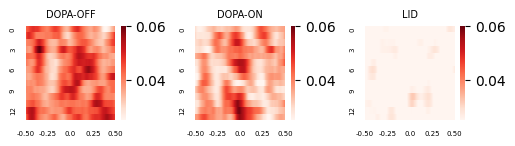

In [10]:
phase_band     = "theta"
amplitude_band = "beta_high"
alignment      = "onset"
normalize      = False

t_vector, freqs, mean_DOPA_OFF, erpacs_DOPA_OFF = utils_phase_analysis.get_mean_erpac_matrix(ERPAC_noLID_noDOPA, ERPAC_baseline, phase_band, amplitude_band, 
                                                                                             alignment, normalize, fs=fs, t_start=-0.5, t_end=0.5)
t_vector, freqs, mean_DOPA_ON , erpacs_DOPA_ON  = utils_phase_analysis.get_mean_erpac_matrix(ERPAC_noLID_DOPA, ERPAC_baseline, phase_band, amplitude_band, 
                                                                                             alignment, normalize, fs=fs, t_start=-0.5, t_end=0.5)
t_vector, freqs, mean_LID     , erpacs_LID      = utils_phase_analysis.get_mean_erpac_matrix(ERPAC_LID, ERPAC_baseline, phase_band, amplitude_band, 
                                                                                             alignment, normalize, fs=fs, t_start=-0.5, t_end=0.5)

## PLOTTING ###########################################################################################################

plt  = utils_plotting.get_figure_template()

ax1  = plt.subplot2grid((100, 100), (0 , 0) , colspan=20, rowspan=15)
ax2  = plt.subplot2grid((100, 100), (0, 30) , colspan=20, rowspan=15)
ax3  = plt.subplot2grid((100, 100), (0, 60) , colspan=20, rowspan=15)

max_value = np.max([mean_DOPA_OFF.max(), mean_DOPA_ON.max(), mean_LID.max()])
min_value = np.max([mean_DOPA_OFF.min(), mean_DOPA_ON.min(), mean_LID.min()])

ax1  = sns.heatmap(data=mean_DOPA_OFF,cmap='Reds', vmin=min_value, vmax=max_value, ax=ax1)
ax2  = sns.heatmap(data=mean_DOPA_ON,cmap='Reds' , vmin=min_value, vmax=max_value, ax=ax2)
ax3  = sns.heatmap(data=mean_LID,cmap='Reds'     , vmin=min_value, vmax=max_value, ax=ax3)

# Manually set ticks at fixed positions (e.g., spread evenly across the x-axis)
tick_positions = [0, mean_LID.shape[1]//4, mean_LID.shape[1]//2, 3*mean_LID.shape[1]//4, mean_LID.shape[1]-1]
tick_labels = ['-0.50', '-0.25', '0.0', '0.25', '0.50']

ax1.set_xticks(tick_positions)
ax1.set_xticklabels(tick_labels, rotation=0)
ax2.set_xticks(tick_positions)
ax2.set_xticklabels(tick_labels, rotation=0)
ax3.set_xticks(tick_positions)
ax3.set_xticklabels(tick_labels, rotation=0)

ax1.set_title("DOPA-OFF", fontsize=utils_plotting.LABEL_SIZE_title)
ax2.set_title("DOPA-ON" , fontsize=utils_plotting.LABEL_SIZE_title)
ax3.set_title("LID"     , fontsize=utils_plotting.LABEL_SIZE_title)

utils_plotting.set_axis(ax1)
utils_plotting.set_axis(ax2)
utils_plotting.set_axis(ax3)

In [37]:
pac_pairs                          = [("theta", "alpha"), ("theta", "beta_low"), ("theta", "beta_high"), ("theta", "gamma"), ("alpha", "beta_low"),
                                      ("alpha", "beta_high"), ("alpha", "gamma"), ("beta_low", "beta_high"), ("beta_low", "gamma"), ("beta_high", "gamma")]
ERPAC_normalized_means             = dict()
ERPAC_normalized_means["DOPA_off"] = dict()
ERPAC_normalized_means["DOPA_on"]  = dict()
ERPAC_normalized_means["LID"]      = dict()

for pha_freq, amp_freq in pac_pairs:

    ERPAC_normalized_means["DOPA_off"][f"{pha_freq}_{amp_freq}"] = dict()
    ERPAC_normalized_means["DOPA_on"][f"{pha_freq}_{amp_freq}"]  = dict()
    ERPAC_normalized_means["LID"][f"{pha_freq}_{amp_freq}"]      = dict()
    
    t_vec, erpac_values, mean_erpac, se_erpac = utils_phase_analysis.get_mean_erpac(ERPAC_noLID_noDOPA, ERPAC_baseline, "theta", "alpha", alignment, fs)
    t_vec, erpac_values, mean_erpac, se_erpac = utils_phase_analysis.get_mean_erpac(ERPAC_noLID_DOPA, ERPAC_baseline, "theta", "alpha", alignment, fs)
    t_vec, erpac_values, mean_erpac, se_erpac = utils_phase_analysis.get_mean_erpac(ERPAC_LID, ERPAC_baseline, "theta", "alpha", alignment, fs)

## 3.2 Measure Mean ERPAC As Line

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

<Figure size 640x480 with 0 Axes>

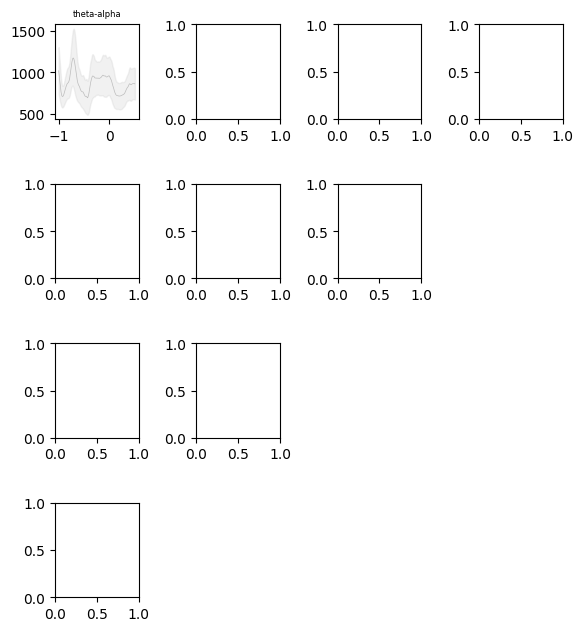

In [12]:
alignment = "onset"
normalize = True

# plot
plt  = utils_plotting.get_figure_template()

ax1  = plt.subplot2grid((100, 100), (0 , 0) , colspan=15, rowspan=15)
ax2  = plt.subplot2grid((100, 100), (25, 0) , colspan=15, rowspan=15)
ax3  = plt.subplot2grid((100, 100), (50, 0) , colspan=15, rowspan=15)
ax4  = plt.subplot2grid((100, 100), (75, 0) , colspan=15, rowspan=15)
ax5  = plt.subplot2grid((100, 100), (0 , 25), colspan=15, rowspan=15)
ax6  = plt.subplot2grid((100, 100), (25, 25), colspan=15, rowspan=15)
ax7  = plt.subplot2grid((100, 100), (50, 25), colspan=15, rowspan=15)
ax8  = plt.subplot2grid((100, 100), (0 , 50), colspan=15, rowspan=15)
ax9  = plt.subplot2grid((100, 100), (25, 50), colspan=15, rowspan=15)
ax10 = plt.subplot2grid((100, 100), (0 , 75), colspan=15, rowspan=15)

### THETA-ALPHA
t_vec, erpac_values, mean_erpac, se_erpac = utils_phase_analysis.get_mean_erpac_line(ERPAC_noLID_noDOPA, ERPAC_baseline, "theta", "alpha", alignment, normalize, fs=fs)
ax1.plot(t_vec, mean_erpac, label='Mean Signal', color=utils_plotting.colors["noLID_noDOPA"], linewidth=0.5)
ax1.fill_between(t_vec, mean_erpac - se_erpac, mean_erpac + se_erpac, color=utils_plotting.colors["noLID_noDOPA"], alpha=0.2, label='± SEM')
ax1.set_title("theta-alpha",fontsize=utils_plotting.LABEL_SIZE_label)

t_vec, erpac_values, mean_erpac, se_erpac = utils_phase_analysis.get_mean_erpac_line(ERPAC_noLID_DOPA, ERPAC_baseline, "theta", "alpha", alignment, normalize, fs=fs)
ax1.plot(t_vec, mean_erpac, label='Mean Signal', color=utils_plotting.colors["noLID_DOPA"], linewidth=0.5)
ax1.fill_between(t_vec, mean_erpac - se_erpac, mean_erpac + se_erpac, color=utils_plotting.colors["noLID_DOPA"], alpha=0.2, label='± SEM')
ax1.set_title("theta-alpha",fontsize=utils_plotting.LABEL_SIZE_label)

t_vec, erpac_values, mean_erpac, se_erpac = utils_phase_analysis.get_mean_erpac_line(ERPAC_LID, ERPAC_baseline, "theta", "alpha", alignment, normalize, fs=fs)
ax1.plot(t_vec, mean_erpac, label='Mean Signal', color=utils_plotting.colors["LID"], linewidth=0.5)
ax1.fill_between(t_vec, mean_erpac - se_erpac, mean_erpac + se_erpac, color=utils_plotting.colors["LID"], alpha=0.2, label='± SEM')
ax1.set_title("theta-alpha",fontsize=utils_plotting.LABEL_SIZE_label)

### THETA-BETA_LOW
t_vec, erpac_values, mean_erpac, se_erpac = utils_phase_analysis.get_mean_erpac_line(ERPAC_noLID_noDOPA, ERPAC_baseline, "theta", "beta_low", alignment, normalize, fs=fs)
ax2.plot(t_vec, mean_erpac, label='Mean Signal', color=utils_plotting.colors["noLID_noDOPA"], linewidth=0.5)
ax2.fill_between(t_vec, mean_erpac - se_erpac, mean_erpac + se_erpac, color=utils_plotting.colors["noLID_noDOPA"], alpha=0.2, label='± SEM')
ax2.set_title("theta-beta_low",fontsize=utils_plotting.LABEL_SIZE_label)

t_vec, erpac_values, mean_erpac, se_erpac = utils_phase_analysis.get_mean_erpac_line(ERPAC_noLID_DOPA, ERPAC_baseline, "theta", "beta_low", alignment, normalize, fs=fs)
ax2.plot(t_vec, mean_erpac, label='Mean Signal', color=utils_plotting.colors["noLID_DOPA"], linewidth=0.5)
ax2.fill_between(t_vec, mean_erpac - se_erpac, mean_erpac + se_erpac, color=utils_plotting.colors["noLID_DOPA"], alpha=0.2, label='± SEM')
ax2.set_title("theta-beta_low",fontsize=utils_plotting.LABEL_SIZE_label)

t_vec, erpac_values, mean_erpac, se_erpac = utils_phase_analysis.get_mean_erpac_line(ERPAC_LID, ERPAC_baseline, "theta", "beta_low", alignment, normalize, fs=fs)
ax2.plot(t_vec, mean_erpac, label='Mean Signal', color=utils_plotting.colors["LID"], linewidth=0.5)
ax2.fill_between(t_vec, mean_erpac - se_erpac, mean_erpac + se_erpac, color=utils_plotting.colors["LID"], alpha=0.2, label='± SEM')
ax2.set_title("theta-beta_low",fontsize=utils_plotting.LABEL_SIZE_label)

### THETA-BETA_HIGH
t_vec, erpac_values, mean_erpac, se_erpac = utils_phase_analysis.get_mean_erpac_line(ERPAC_noLID_noDOPA, ERPAC_baseline, "theta", "beta_high", alignment, normalize, fs=fs)
ax3.plot(t_vec, mean_erpac, label='Mean Signal', color=utils_plotting.colors["noLID_noDOPA"], linewidth=0.5)
ax3.fill_between(t_vec, mean_erpac - se_erpac, mean_erpac + se_erpac, color=utils_plotting.colors["noLID_noDOPA"], alpha=0.2, label='± SEM')
ax3.set_title("theta-beta_high",fontsize=utils_plotting.LABEL_SIZE_label)

t_vec, erpac_values, mean_erpac, se_erpac = utils_phase_analysis.get_mean_erpac_line(ERPAC_noLID_DOPA, ERPAC_baseline, "theta", "beta_high", alignment, normalize, fs=fs)
ax3.plot(t_vec, mean_erpac, label='Mean Signal', color=utils_plotting.colors["noLID_DOPA"], linewidth=0.5)
ax3.fill_between(t_vec, mean_erpac - se_erpac, mean_erpac + se_erpac, color=utils_plotting.colors["noLID_DOPA"], alpha=0.2, label='± SEM')
ax3.set_title("theta-beta_high",fontsize=utils_plotting.LABEL_SIZE_label)

t_vec, erpac_values, mean_erpac, se_erpac = utils_phase_analysis.get_mean_erpac_line(ERPAC_LID, ERPAC_baseline, "theta", "beta_high", alignment, normalize, fs=fs)
ax3.plot(t_vec, mean_erpac, label='Mean Signal', color=utils_plotting.colors["LID"], linewidth=0.5)
ax3.fill_between(t_vec, mean_erpac - se_erpac, mean_erpac + se_erpac, color=utils_plotting.colors["LID"], alpha=0.2, label='± SEM')
ax3.set_title("theta-beta_high",fontsize=utils_plotting.LABEL_SIZE_label)

### THETA-GAMMA
t_vec, erpac_values, mean_erpac, se_erpac = utils_phase_analysis.get_mean_erpac_line(ERPAC_noLID_noDOPA, ERPAC_baseline, "theta", "gamma", alignment, normalize, fs=fs)
ax4.plot(t_vec, mean_erpac, label='Mean Signal', color=utils_plotting.colors["noLID_noDOPA"], linewidth=0.5)
ax4.fill_between(t_vec, mean_erpac - se_erpac, mean_erpac + se_erpac, color=utils_plotting.colors["noLID_noDOPA"], alpha=0.2, label='± SEM')
ax4.set_title("theta-gamma",fontsize=utils_plotting.LABEL_SIZE_label)

t_vec, erpac_values, mean_erpac, se_erpac = utils_phase_analysis.get_mean_erpac_line(ERPAC_noLID_DOPA, ERPAC_baseline, "theta", "gamma", alignment, normalize, fs=fs)
ax4.plot(t_vec, mean_erpac, label='Mean Signal', color=utils_plotting.colors["noLID_DOPA"], linewidth=0.5)
ax4.fill_between(t_vec, mean_erpac - se_erpac, mean_erpac + se_erpac, color=utils_plotting.colors["noLID_DOPA"], alpha=0.2, label='± SEM')
ax4.set_title("theta-gamma",fontsize=utils_plotting.LABEL_SIZE_label)

t_vec, erpac_values, mean_erpac, se_erpac = utils_phase_analysis.get_mean_erpac_line(ERPAC_LID, ERPAC_baseline, "theta", "gamma", alignment, normalize, fs=fs)
ax4.plot(t_vec, mean_erpac, label='Mean Signal', color=utils_plotting.colors["LID"], linewidth=0.5)
ax4.fill_between(t_vec, mean_erpac - se_erpac, mean_erpac + se_erpac, color=utils_plotting.colors["LID"], alpha=0.2, label='± SEM')
ax4.set_title("theta-gamma",fontsize=utils_plotting.LABEL_SIZE_label)

### ALPHA-BETA LOW
t_vec, erpac_values, mean_erpac, se_erpac = utils_phase_analysis.get_mean_erpac_line(ERPAC_noLID_noDOPA, ERPAC_baseline, "alpha", "beta_low", alignment, normalize, fs=fs)
ax5.plot(t_vec, mean_erpac, label='Mean Signal', color=utils_plotting.colors["noLID_noDOPA"], linewidth=0.5)
ax5.fill_between(t_vec, mean_erpac - se_erpac, mean_erpac + se_erpac, color=utils_plotting.colors["noLID_noDOPA"], alpha=0.2, label='± SEM')
ax5.set_title("alpha-beta_low",fontsize=utils_plotting.LABEL_SIZE_label)

t_vec, erpac_values, mean_erpac, se_erpac = utils_phase_analysis.get_mean_erpac_line(ERPAC_noLID_DOPA, ERPAC_baseline, "alpha", "beta_low", alignment, normalize, fs=fs)
ax5.plot(t_vec, mean_erpac, label='Mean Signal', color=utils_plotting.colors["noLID_DOPA"], linewidth=0.5)
ax5.fill_between(t_vec, mean_erpac - se_erpac, mean_erpac + se_erpac, color=utils_plotting.colors["noLID_DOPA"], alpha=0.2, label='± SEM')
ax5.set_title("alpha-beta_low",fontsize=utils_plotting.LABEL_SIZE_label)

t_vec, erpac_values, mean_erpac, se_erpac = utils_phase_analysis.get_mean_erpac_line(ERPAC_LID, ERPAC_baseline, "alpha", "beta_low", alignment, normalize, fs=fs)
ax5.plot(t_vec, mean_erpac, label='Mean Signal', color=utils_plotting.colors["LID"], linewidth=0.5)
ax5.fill_between(t_vec, mean_erpac - se_erpac, mean_erpac + se_erpac, color=utils_plotting.colors["LID"], alpha=0.2, label='± SEM')
ax5.set_title("alpha-beta_low",fontsize=utils_plotting.LABEL_SIZE_label)

### ALPHA-BETA HIGH
t_vec, erpac_values, mean_erpac, se_erpac = utils_phase_analysis.get_mean_erpac_line(ERPAC_noLID_noDOPA, ERPAC_baseline, "alpha", "beta_high", alignment, normalize, fs=fs)
ax6.plot(t_vec, mean_erpac, label='Mean Signal', color=utils_plotting.colors["noLID_noDOPA"], linewidth=0.5)
ax6.fill_between(t_vec, mean_erpac - se_erpac, mean_erpac + se_erpac, color=utils_plotting.colors["noLID_noDOPA"], alpha=0.2, label='± SEM')
ax6.set_title("alpha-beta_high",fontsize=utils_plotting.LABEL_SIZE_label)

t_vec, erpac_values, mean_erpac, se_erpac = utils_phase_analysis.get_mean_erpac_line(ERPAC_noLID_DOPA, ERPAC_baseline, "alpha", "beta_high", alignment, normalize, fs=fs)
ax6.plot(t_vec, mean_erpac, label='Mean Signal', color=utils_plotting.colors["noLID_DOPA"], linewidth=0.5)
ax6.fill_between(t_vec, mean_erpac - se_erpac, mean_erpac + se_erpac, color=utils_plotting.colors["noLID_DOPA"], alpha=0.2, label='± SEM')
ax6.set_title("alpha-beta_high",fontsize=utils_plotting.LABEL_SIZE_label)

t_vec, erpac_values, mean_erpac, se_erpac = utils_phase_analysis.get_mean_erpac_line(ERPAC_LID, ERPAC_baseline, "alpha", "beta_high", alignment, normalize, fs=fs)
ax6.plot(t_vec, mean_erpac, label='Mean Signal', color=utils_plotting.colors["LID"], linewidth=0.5)
ax6.fill_between(t_vec, mean_erpac - se_erpac, mean_erpac + se_erpac, color=utils_plotting.colors["LID"], alpha=0.2, label='± SEM')
ax6.set_title("alpha-beta_high",fontsize=utils_plotting.LABEL_SIZE_label)

### ALPHA-GAMMA
t_vec, erpac_values, mean_erpac, se_erpac = utils_phase_analysis.get_mean_erpac_line(ERPAC_noLID_noDOPA, ERPAC_baseline, "alpha", "gamma", alignment, normalize, fs=fs)
ax7.plot(t_vec, mean_erpac, label='Mean Signal', color=utils_plotting.colors["noLID_noDOPA"], linewidth=0.5)
ax7.fill_between(t_vec, mean_erpac - se_erpac, mean_erpac + se_erpac, color=utils_plotting.colors["noLID_noDOPA"], alpha=0.2, label='± SEM')
ax7.set_title("alpha-gamma",fontsize=utils_plotting.LABEL_SIZE_label)

t_vec, erpac_values, mean_erpac, se_erpac = utils_phase_analysis.get_mean_erpac_line(ERPAC_noLID_DOPA, ERPAC_baseline, "alpha", "gamma", alignment, normalize, fs=fs)
ax7.plot(t_vec, mean_erpac, label='Mean Signal', color=utils_plotting.colors["noLID_DOPA"], linewidth=0.5)
ax7.fill_between(t_vec, mean_erpac - se_erpac, mean_erpac + se_erpac, color=utils_plotting.colors["noLID_DOPA"], alpha=0.2, label='± SEM')
ax7.set_title("alpha-gamma",fontsize=utils_plotting.LABEL_SIZE_label)

t_vec, erpac_values, mean_erpac, se_erpac = utils_phase_analysis.get_mean_erpac_line(ERPAC_LID, ERPAC_baseline, "alpha", "gamma", alignment, normalize, fs=fs)
ax7.plot(t_vec, mean_erpac, label='Mean Signal', color=utils_plotting.colors["LID"], linewidth=0.5)
ax7.fill_between(t_vec, mean_erpac - se_erpac, mean_erpac + se_erpac, color=utils_plotting.colors["LID"], alpha=0.2, label='± SEM')
ax7.set_title("alpha-gamma",fontsize=utils_plotting.LABEL_SIZE_label)

### BETA LOW-BETA HIGH
t_vec, erpac_values, mean_erpac, se_erpac = utils_phase_analysis.get_mean_erpac_line(ERPAC_noLID_noDOPA, ERPAC_baseline, "beta_low", "beta_high", alignment, normalize, fs=fs)
ax8.plot(t_vec, mean_erpac, label='Mean Signal', color=utils_plotting.colors["noLID_noDOPA"], linewidth=0.5)
ax8.fill_between(t_vec, mean_erpac - se_erpac, mean_erpac + se_erpac, color=utils_plotting.colors["noLID_noDOPA"], alpha=0.2, label='± SEM')
ax8.set_title("beta_low-beta_high",fontsize=utils_plotting.LABEL_SIZE_label)

t_vec, erpac_values, mean_erpac, se_erpac = utils_phase_analysis.get_mean_erpac_line(ERPAC_noLID_DOPA, ERPAC_baseline, "beta_low", "beta_high", alignment, normalize, fs=fs)
ax8.plot(t_vec, mean_erpac, label='Mean Signal', color=utils_plotting.colors["noLID_DOPA"], linewidth=0.5)
ax8.fill_between(t_vec, mean_erpac - se_erpac, mean_erpac + se_erpac, color=utils_plotting.colors["noLID_DOPA"], alpha=0.2, label='± SEM')
ax8.set_title("beta_low-beta_high",fontsize=utils_plotting.LABEL_SIZE_label)

t_vec, erpac_values, mean_erpac, se_erpac = utils_phase_analysis.get_mean_erpac_line(ERPAC_LID, ERPAC_baseline, "beta_low", "beta_high", alignment, normalize, fs=fs)
ax8.plot(t_vec, mean_erpac, label='Mean Signal', color=utils_plotting.colors["LID"], linewidth=0.5)
ax8.fill_between(t_vec, mean_erpac - se_erpac, mean_erpac + se_erpac, color=utils_plotting.colors["LID"], alpha=0.2, label='± SEM')
ax8.set_title("beta_low-beta_high",fontsize=utils_plotting.LABEL_SIZE_label)

### BETA LOW-GAMMA
t_vec, erpac_values, mean_erpac, se_erpac = utils_phase_analysis.get_mean_erpac_line(ERPAC_noLID_noDOPA, ERPAC_baseline, "beta_low", "gamma", alignment, normalize, fs=fs)
ax9.plot(t_vec, mean_erpac, label='Mean Signal', color=utils_plotting.colors["noLID_noDOPA"], linewidth=0.5)
ax9.fill_between(t_vec, mean_erpac - se_erpac, mean_erpac + se_erpac, color=utils_plotting.colors["noLID_noDOPA"], alpha=0.2, label='± SEM')
ax9.set_title("beta_low-gamma",fontsize=utils_plotting.LABEL_SIZE_label)

t_vec, erpac_values, mean_erpac, se_erpac = utils_phase_analysis.get_mean_erpac_line(ERPAC_noLID_DOPA, ERPAC_baseline, "beta_low", "gamma", alignment, normalize, fs=fs)
ax9.plot(t_vec, mean_erpac, label='Mean Signal', color=utils_plotting.colors["noLID_DOPA"], linewidth=0.5)
ax9.fill_between(t_vec, mean_erpac - se_erpac, mean_erpac + se_erpac, color=utils_plotting.colors["noLID_DOPA"], alpha=0.2, label='± SEM')
ax9.set_title("beta_low-gamma",fontsize=utils_plotting.LABEL_SIZE_label)

t_vec, erpac_values, mean_erpac, se_erpac = utils_phase_analysis.get_mean_erpac_line(ERPAC_LID, ERPAC_baseline, "beta_low", "gamma", alignment, normalize, fs=fs)
ax9.plot(t_vec, mean_erpac, label='Mean Signal', color=utils_plotting.colors["LID"], linewidth=0.5)
ax9.fill_between(t_vec, mean_erpac - se_erpac, mean_erpac + se_erpac, color=utils_plotting.colors["LID"], alpha=0.2, label='± SEM')
ax9.set_title("beta_low-gamma",fontsize=utils_plotting.LABEL_SIZE_label)

### BETA HIGH-GAMMA
t_vec, erpac_values, mean_erpac, se_erpac = utils_phase_analysis.get_mean_erpac_line(ERPAC_noLID_noDOPA, ERPAC_baseline, "beta_high", "gamma", alignment, normalize, fs=fs)
ax10.plot(t_vec, mean_erpac, label='Mean Signal', color=utils_plotting.colors["noLID_noDOPA"], linewidth=0.5)
ax10.fill_between(t_vec, mean_erpac - se_erpac, mean_erpac + se_erpac, color=utils_plotting.colors["noLID_noDOPA"], alpha=0.2, label='± SEM')
ax10.set_title("beta_high-gamma",fontsize=utils_plotting.LABEL_SIZE_label)

t_vec, erpac_values, mean_erpac, se_erpac = utils_phase_analysis.get_mean_erpac_line(ERPAC_noLID_DOPA, ERPAC_baseline, "beta_high", "gamma", alignment, normalize, fs=fs)
ax10.plot(t_vec, mean_erpac, label='Mean Signal', color=utils_plotting.colors["noLID_DOPA"], linewidth=0.5)
ax10.fill_between(t_vec, mean_erpac - se_erpac, mean_erpac + se_erpac, color=utils_plotting.colors["noLID_DOPA"], alpha=0.2, label='± SEM')
ax10.set_title("beta_high-gamma",fontsize=utils_plotting.LABEL_SIZE_label)

t_vec, erpac_values, mean_erpac, se_erpac = utils_phase_analysis.get_mean_erpac_line(ERPAC_LID, ERPAC_baseline, "beta_high", "gamma", alignment, normalize, fs=fs)
ax10.plot(t_vec, mean_erpac, label='Mean Signal', color=utils_plotting.colors["LID"], linewidth=0.5)
ax10.fill_between(t_vec, mean_erpac - se_erpac, mean_erpac + se_erpac, color=utils_plotting.colors["LID"], alpha=0.2, label='± SEM')
ax10.set_title("beta_high-gamma",fontsize=utils_plotting.LABEL_SIZE_label)

utils_plotting.set_axis(ax1)
utils_plotting.set_axis(ax2)
utils_plotting.set_axis(ax3)
utils_plotting.set_axis(ax4)
utils_plotting.set_axis(ax5)
utils_plotting.set_axis(ax6)
utils_plotting.set_axis(ax7)
utils_plotting.set_axis(ax8)
utils_plotting.set_axis(ax9)
utils_plotting.set_axis(ax10)

#ax1.set_ylim([0,0.03])
#ax2.set_ylim([0,0.03])
#ax3.set_ylim([0,0.03])
#ax4.set_ylim([0,0.03])
#ax5.set_ylim([0,0.03])
#ax6.set_ylim([0,0.03])
#ax7.set_ylim([0,0.03])
#ax8.set_ylim([0,0.03])
#ax9.set_ylim([0,0.03])
#ax10.set_ylim([0,0.03])